## Notlar
* 2019'da satışlar düşmüş. Covidten dolayı olabilir. Modellemede bunu da ekleyebiliriz.


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,LabelEncoder
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor,XGBRFRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from prophet import Prophet
from datetime import timedelta
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
import warnings
warnings.filterwarnings("ignore")

C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def smape(y_true, y_pred):
    """
    SMAPE (Symmetric Mean Absolute Percentage Error) hesaplayan fonksiyon.
    
    Args:
    y_true (array-like): Gerçek değerler.
    y_pred (array-like): Tahmin edilen değerler.
    
    Returns:
    float: SMAPE değeri.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

In [3]:
data = pd.read_excel(os.getcwd() + "/data/ODMD_MainData.xlsx")
data = data.sort_values(ascending=True,by="Date")
data.loc[data.MARKA == "KG MOBILITY – SSANGYONG",'MARKA'] = "SSANGYONG" 
## 0 olan satıs aylarını cıkar.
data = data[data.TTL_TOPLAM != 0]

In [4]:
data.head(5)

,MARKA,YERLI_ADET,ITHAL_ADET,TOPLAM,HT_YERLI,HT_ITHAL,HT_TOPLAM,TTL_YERLI,TTL_ITHAL,TTL_TOPLAM,Date
5032,LANCIA,0,8,8,0,0,0,0,8,8,2014-01-01
5035,MASERATI,0,6,6,0,0,0,0,6,6,2014-01-01
5036,MAZDA,0,30,30,0,0,0,0,30,30,2014-01-01
5037,MERCEDES-BENZ,0,582,582,0,490,490,0,1072,1072,2014-01-01
5038,MINI,0,51,51,0,0,0,0,51,51,2014-01-01


In [5]:
monthly_data = data[["Date","TTL_TOPLAM"]].groupby("Date").agg({"TTL_TOPLAM":"sum"}).reset_index()
monthly_data.head(5)

,Date,TTL_TOPLAM
0,2014-01-01,32670
1,2014-02-01,35021
2,2014-03-01,47581
3,2014-04-01,53305
4,2014-05-01,58121


In [6]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        127 non-null    datetime64[ns]
 1   TTL_TOPLAM  127 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.1 KB


In [7]:
monthly_data

,Date,TTL_TOPLAM
0,2014-01-01,32670
1,2014-02-01,35021
2,2014-03-01,47581
3,2014-04-01,53305
4,2014-05-01,58121
...,...,...
122,2024-03-01,109828
123,2024-04-01,75919
124,2024-05-01,100305
125,2024-06-01,106238


In [8]:
## add month & Quarter features
monthly_data["Month"] = monthly_data.Date.dt.month
monthly_data["Quarter"] = monthly_data.Date.dt.quarter
monthly_data["Year"] = monthly_data.Date.dt.year


## Avg - Median & Total Sales by Month / Quarter / Year
month = monthly_data[["Month","TTL_TOPLAM"]].groupby("Month").agg(
    TotalSales = ("TTL_TOPLAM", np.sum),
    AvgSales = ("TTL_TOPLAM", np.mean),
    MedianSales = ("TTL_TOPLAM", np.median)
).reset_index(names="Month")

month["Month"] = month["Month"].astype("str")


quarter = monthly_data[["Quarter","TTL_TOPLAM"]].groupby("Quarter").agg(
    TotalSales = ("TTL_TOPLAM", np.sum),
    AvgSales = ("TTL_TOPLAM", np.mean),
    MedianSales = ("TTL_TOPLAM", np.median)
).reset_index(names="Quarter")

quarter["Quarter"] = quarter["Quarter"].astype("str")


year = monthly_data[["Year","TTL_TOPLAM"]].groupby("Year").agg(
    TotalSales = ("TTL_TOPLAM", np.sum),
    AvgSales = ("TTL_TOPLAM", np.mean),
    MedianSales = ("TTL_TOPLAM", np.median)
).reset_index(names="Year")

year["Year"] = year["Year"].astype("str")

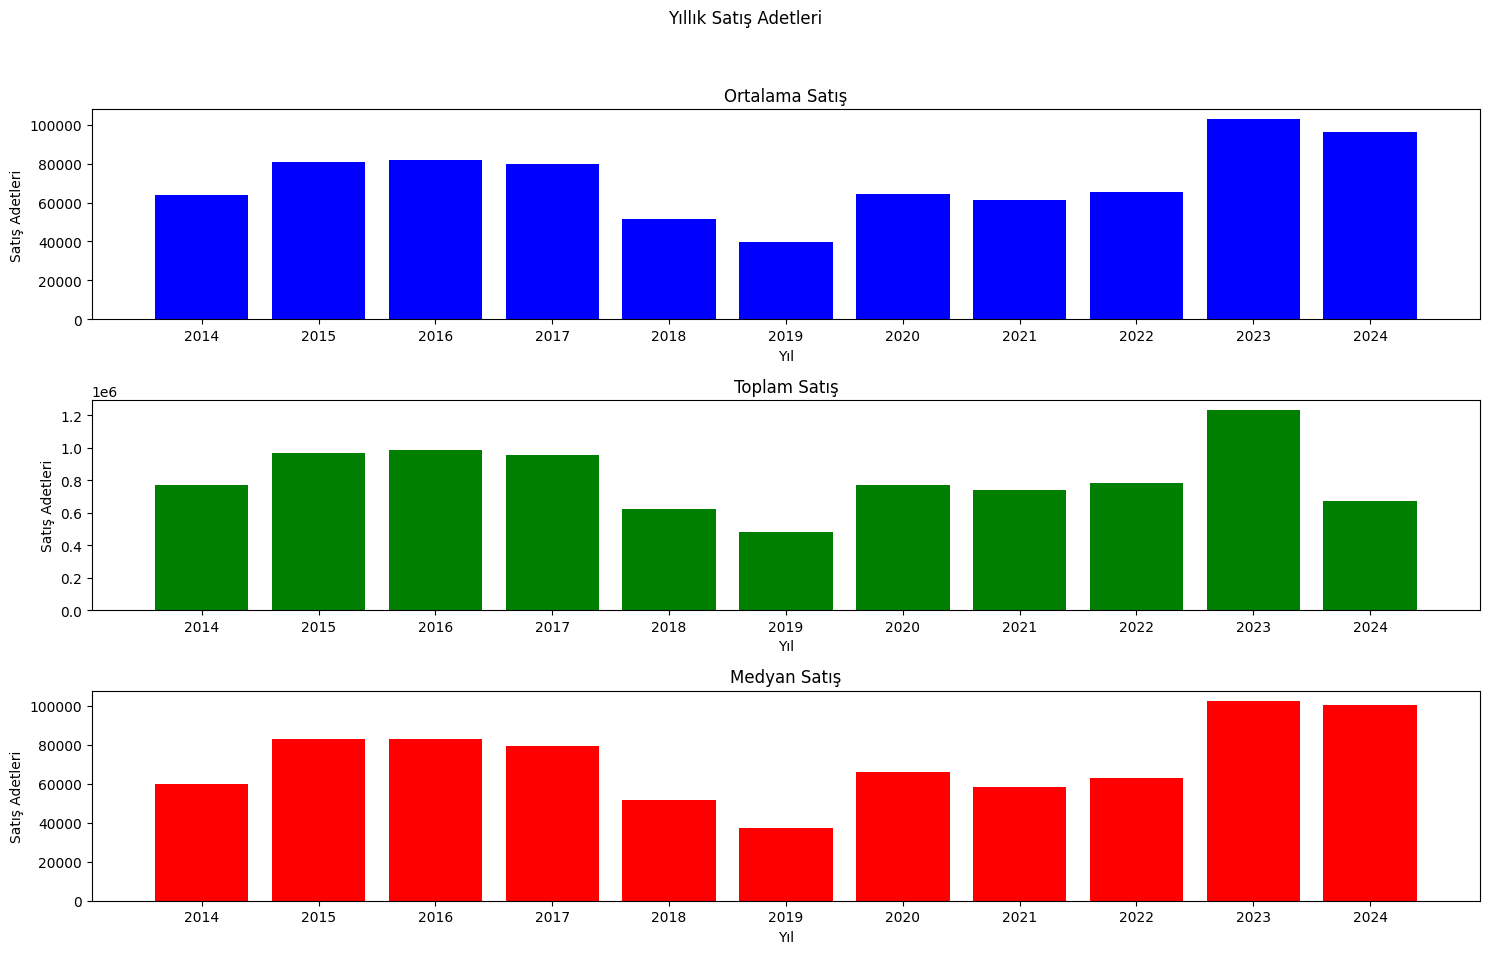

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

# Ortalama Satış çubukları
axs[0].bar(year["Year"], year["AvgSales"], color='b')
axs[0].set_title('Ortalama Satış')
axs[0].set_xlabel('Yıl')
axs[0].set_ylabel('Satış Adetleri')

# Toplam Satış çubukları
axs[1].bar(year["Year"], year["TotalSales"], color='g')
axs[1].set_title('Toplam Satış')
axs[1].set_xlabel('Yıl')
axs[1].set_ylabel('Satış Adetleri')

# Medyan Satış çubukları
axs[2].bar(year["Year"], year["MedianSales"], color='r')
axs[2].set_title('Medyan Satış')
axs[2].set_xlabel('Yıl')
axs[2].set_ylabel('Satış Adetleri')

# Grafik başlığı ve düzenlemeler
plt.suptitle('Yıllık Satış Adetleri')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Grafiği göster
plt.show()

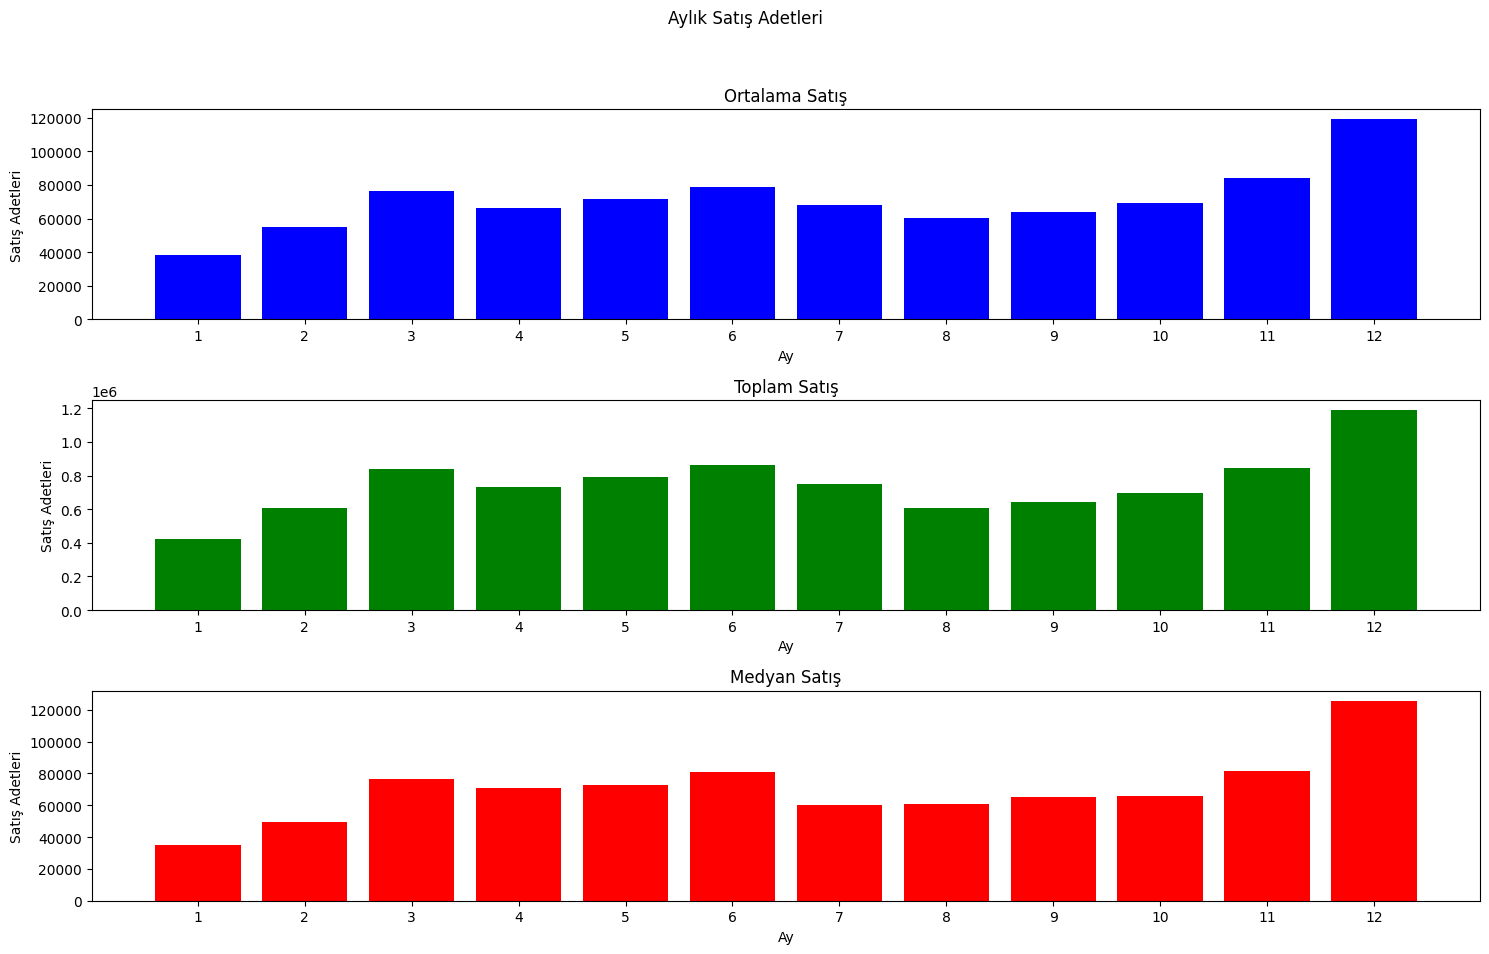

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

# Ortalama Satış çubukları
axs[0].bar(month["Month"], month["AvgSales"], color='b')
axs[0].set_title('Ortalama Satış')
axs[0].set_xlabel('Ay')
axs[0].set_ylabel('Satış Adetleri')

# Toplam Satış çubukları
axs[1].bar(month["Month"], month["TotalSales"], color='g')
axs[1].set_title('Toplam Satış')
axs[1].set_xlabel('Ay')
axs[1].set_ylabel('Satış Adetleri')

# Medyan Satış çubukları
axs[2].bar(month["Month"], month["MedianSales"], color='r')
axs[2].set_title('Medyan Satış')
axs[2].set_xlabel('Ay')
axs[2].set_ylabel('Satış Adetleri')

# Grafik başlığı ve düzenlemeler
plt.suptitle('Aylık Satış Adetleri')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Grafiği göster
plt.show()

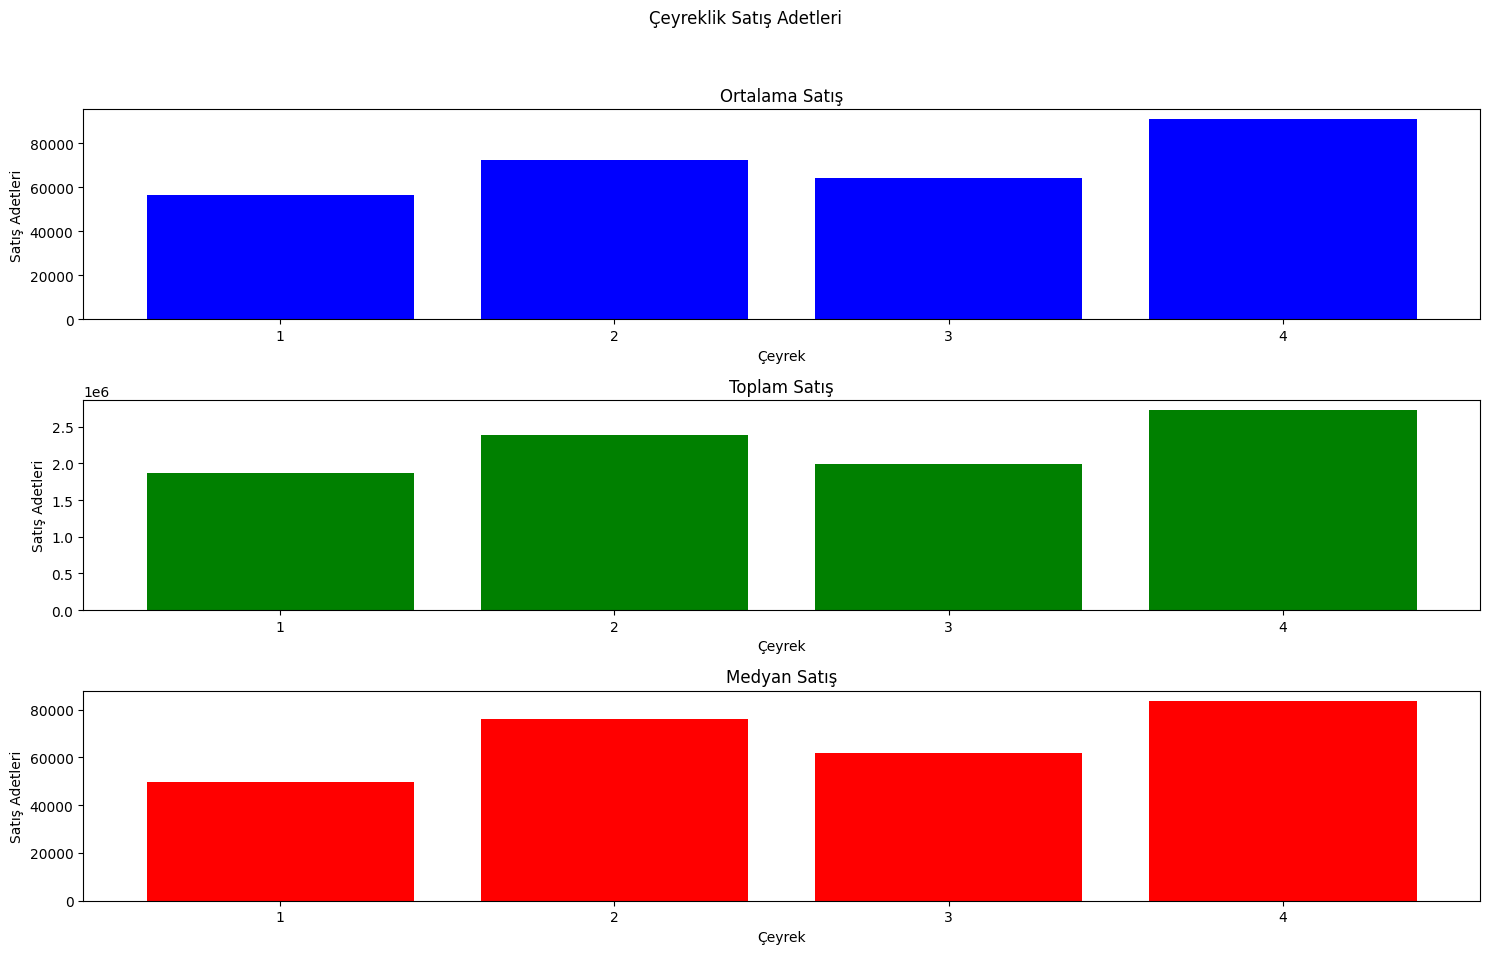

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

# Ortalama Satış çubukları
axs[0].bar(quarter["Quarter"], quarter["AvgSales"], color='b')
axs[0].set_title('Ortalama Satış')
axs[0].set_xlabel('Çeyrek')
axs[0].set_ylabel('Satış Adetleri')

# Toplam Satış çubukları
axs[1].bar(quarter["Quarter"], quarter["TotalSales"], color='g')
axs[1].set_title('Toplam Satış')
axs[1].set_xlabel('Çeyrek')
axs[1].set_ylabel('Satış Adetleri')

# Medyan Satış çubukları
axs[2].bar(quarter["Quarter"], quarter["MedianSales"], color='r')
axs[2].set_title('Medyan Satış')
axs[2].set_xlabel('Çeyrek')
axs[2].set_ylabel('Satış Adetleri')

# Grafik başlığı ve düzenlemeler
plt.suptitle('Çeyreklik Satış Adetleri')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Grafiği göster
plt.show()

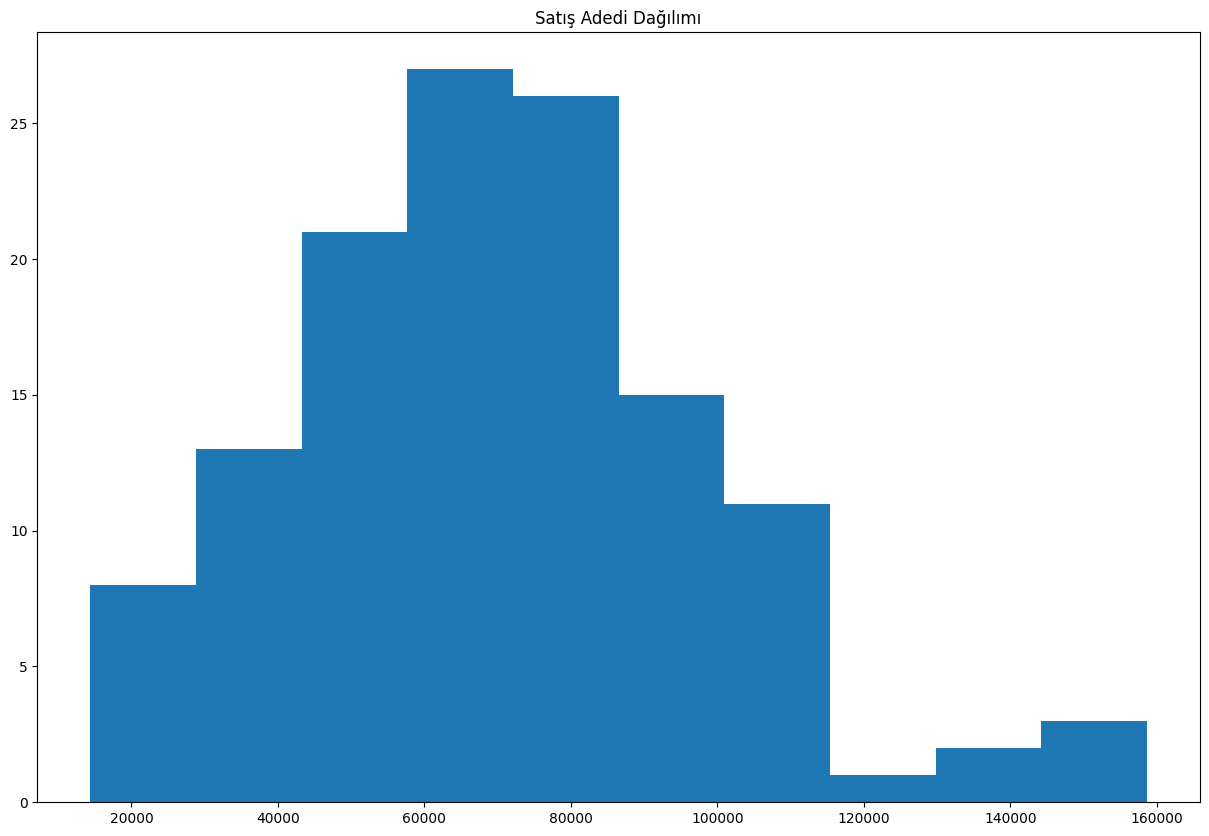

In [12]:
plt.figure(figsize=(15,10))
plt.hist(monthly_data.TTL_TOPLAM)
plt.title("Satış Adedi Dağılımı")
plt.show()

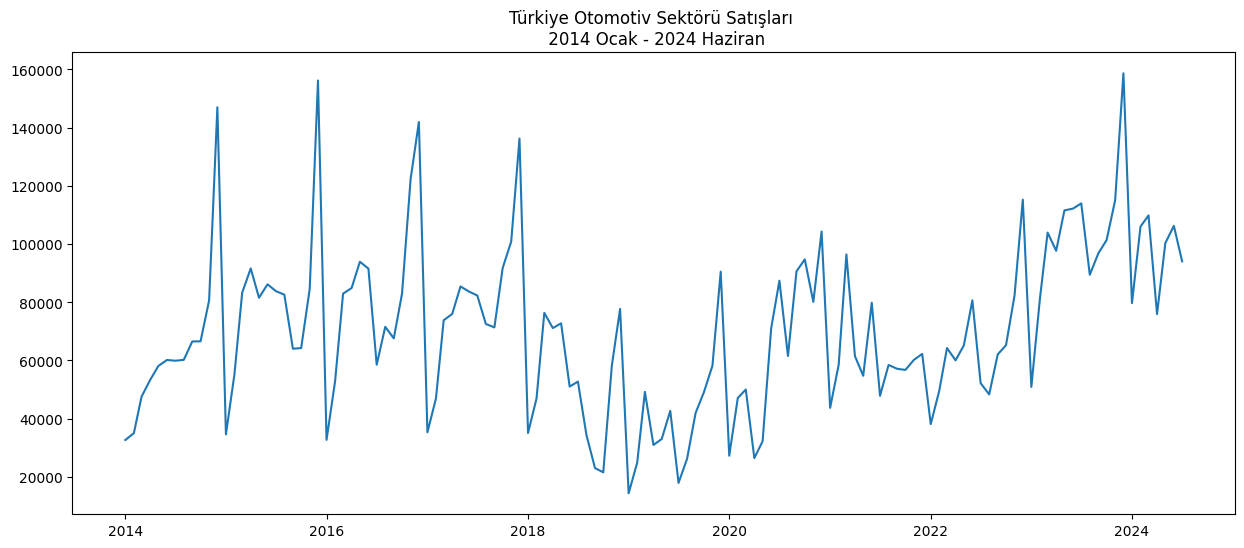

In [13]:
plt.figure(figsize=(15,6))
plt.plot(monthly_data["Date"],monthly_data["TTL_TOPLAM"])

plt.title("Türkiye Otomotiv Sektörü Satışları \n 2014 Ocak - 2024 Haziran")
plt.show()

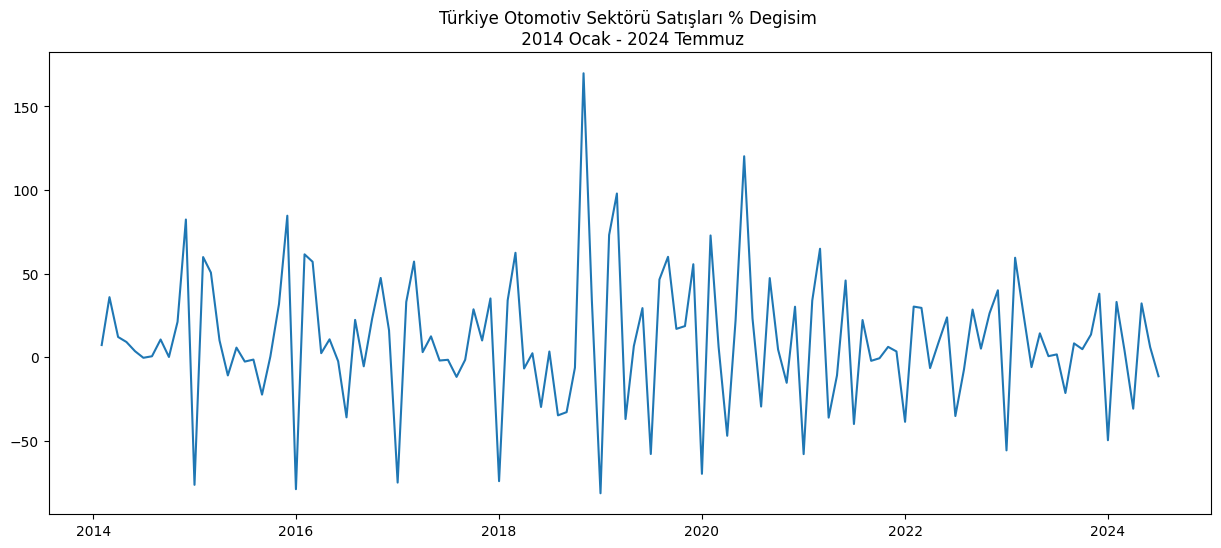

In [14]:
plt.figure(figsize=(15,6))
plt.plot(monthly_data["Date"],monthly_data["TTL_TOPLAM"].pct_change() * 100)

plt.title("Türkiye Otomotiv Sektörü Satışları % Degisim \n 2014 Ocak - 2024 Temmuz")
plt.show()

In [15]:
monthly_data.isna().sum()

Date          0
TTL_TOPLAM    0
Month         0
Quarter       0
Year          0
dtype: int64

In [16]:
## get evds data
from evds_data import GetData

ob = GetData()

eco_data = ob.request_evds()
eco_data.tail()

TP.KTF11-TP.FG.J071-TP.FG.J0-TP.BRENTPETROL.EUBP-TP.KREDI.L013-TP.GY9.N2.MA-TP.YISGUCU2.G2-TP.YISGUCU2.G8-TP.HKFE01-TP.BEK.S01.A.S-TP.BEK.S01.D.S-TP.TG2.Y01-TP.APIFON4-TP.TRY.MT02-TP.TG2.Y08-TP.TG2.Y09-TP.TG2.Y17-TP.UR.S08-TP.UR.S11-TP.KKM.K2-TP.DK.EUR.A.YTL-TP.DK.USD.A.YTL


,Tarih,Tasit_Kredi_Faiz_Oran,Arac_Satin_Alim_Tufe,Genel_Enflasyon_Tufe,EU_Brent_Petrol_Spot,Ticari_Bireysel_Kredi,Guven_Endeksi,Isgucu,Issizlik_Oran,Konut_Fiyat_Endeksi,...,DTM_Uygunluk,DTM_Harcama_Dusuncesi,Otomobil_Alma_Ihtimali,Otomobil_Uretim_Binek,Otomobil_Uretim_Kamyonet,KKM_Paralari_USD_Karsiligi,Euro_TL,USD_TL,TUFE_Change,Arac_Satin_Alim_Tufe_Change
122,2024-03-01,43.8980,1878.20,2139.47,86.17,6.624698e+09,91.1,35361.0,8.8,1230.1,...,55.657753,97.025251,19.204838,87260.0,40140.0,52.1,34.713729,31.929219,3.162671,2.512321
123,2024-04-01,38.0575,1903.23,2207.50,88.23,6.644192e+09,92.9,35244.0,8.5,1257.6,...,47.108151,95.834394,17.830519,61835.0,28630.0,51.6,34.633211,32.271328,3.179759,1.332659
124,2024-05-01,37.4500,1961.85,2281.85,79.41,6.780748e+09,95.0,36004.0,7.7,1273.5,...,48.065050,95.594032,17.757170,91823.0,30125.0,48.9,34.782432,32.189895,3.368063,3.080027
125,2024-06-01,36.8550,1943.18,2319.29,87.26,6.927558e+09,92.7,NaN,NaN,NaN,...,43.954371,94.049861,18.768351,68811.0,23094.0,45.7,34.981735,32.462747,1.640774,-0.951653
126,2024-07-01,53.7350,1959.28,2394.10,80.94,6.954457e+09,86.4,NaN,NaN,NaN,...,44.842265,96.498011,19.446897,NaN,NaN,NaN,35.576541,32.835327,3.225556,0.828539


In [17]:
## concat sales & eco features
sales_data = monthly_data.merge(eco_data,left_on="Date",right_on="Tarih",how="left").drop("Tarih",axis= 1)

In [18]:
sales_data.corr()

,TTL_TOPLAM,Month,Quarter,Year,Tasit_Kredi_Faiz_Oran,Arac_Satin_Alim_Tufe,Genel_Enflasyon_Tufe,EU_Brent_Petrol_Spot,Ticari_Bireysel_Kredi,Guven_Endeksi,...,DTM_Uygunluk,DTM_Harcama_Dusuncesi,Otomobil_Alma_Ihtimali,Otomobil_Uretim_Binek,Otomobil_Uretim_Kamyonet,KKM_Paralari_USD_Karsiligi,Euro_TL,USD_TL,TUFE_Change,Arac_Satin_Alim_Tufe_Change
TTL_TOPLAM,1.000000,0.432896,0.363247,0.129822,0.147587,0.363315,0.366965,-0.061153,0.389416,0.256355,...,0.171776,-0.004943,0.369062,0.331312,0.385647,0.782056,0.348254,0.349155,0.014848,-0.006249
Month,0.432896,1.000000,0.971244,-0.068083,0.008498,-0.007875,-0.027984,-0.077887,-0.013491,0.012660,...,-0.067997,-0.084786,-0.126777,0.165469,0.199115,0.047110,-0.008552,-0.003076,-0.052342,0.048775
Quarter,0.363247,0.971244,1.000000,-0.066017,0.018494,-0.007060,-0.026464,-0.074139,-0.013454,0.006905,...,-0.070794,-0.072773,-0.106181,0.131450,0.161065,0.053341,-0.008097,-0.002414,-0.023420,0.035333
Year,0.129822,-0.068083,-0.066017,1.000000,0.748595,0.841535,0.813489,0.279400,0.847379,-0.119307,...,-0.801660,-0.535272,0.390400,0.038703,-0.104982,0.785946,0.857392,0.853199,0.547517,0.193439
Tasit_Kredi_Faiz_Oran,0.147587,0.008498,0.018494,0.748595,1.000000,0.870743,0.859494,0.418372,0.844725,-0.259531,...,-0.506436,-0.280590,0.457335,0.080471,-0.056567,0.690586,0.871556,0.868437,0.535386,0.125817
Arac_Satin_Alim_Tufe,0.363315,-0.007875,-0.007060,0.841535,0.870743,1.000000,0.991714,0.428545,0.993367,-0.130957,...,-0.486300,-0.419200,0.590397,0.024744,-0.082377,0.809533,0.998023,0.997777,0.565447,0.167877
Genel_Enflasyon_Tufe,0.366965,-0.027984,-0.026464,0.813489,0.859494,0.991714,1.000000,0.401610,0.991672,-0.119409,...,-0.439189,-0.365396,0.623691,0.033574,-0.084468,0.756237,0.990333,0.990789,0.503758,0.114688
EU_Brent_Petrol_Spot,-0.061153,-0.077887,-0.074139,0.279400,0.418372,0.428545,0.401610,1.000000,0.384788,-0.141734,...,-0.205798,-0.231311,0.227932,-0.160691,-0.104045,-0.650430,0.429219,0.427364,0.427483,0.104019
Ticari_Bireysel_Kredi,0.389416,-0.013491,-0.013454,0.847379,0.844725,0.993367,0.991672,0.384788,1.000000,-0.103800,...,-0.471289,-0.385536,0.629635,0.041505,-0.075049,0.872794,0.992610,0.992182,0.512558,0.144848
Guven_Endeksi,0.256355,0.012660,0.006905,-0.119307,-0.259531,-0.130957,-0.119409,-0.141734,-0.103800,1.000000,...,0.303082,0.345785,0.274740,0.222536,0.217431,0.820823,-0.144069,-0.155722,-0.318832,-0.282563


In [19]:
columns = [
    "Date","TTL_TOPLAM","Month","Quarter","Year","Tasit_Kredi_Faiz_Oran",
    "Arac_Satin_Alim_Tufe","Genel_Enflasyon_Tufe","Ticari_Bireysel_Kredi","Otomobil_Alma_Ihtimali",
    "Issizlik_Oran","Konut_Fiyat_Endeksi","USD_TL","Faiz","Mevduat_Faizi"]

In [20]:
sales_data.isna().sum()

Date                            0
TTL_TOPLAM                      0
Month                           0
Quarter                         0
Year                            0
Tasit_Kredi_Faiz_Oran           0
Arac_Satin_Alim_Tufe            0
Genel_Enflasyon_Tufe            0
EU_Brent_Petrol_Spot            0
Ticari_Bireysel_Kredi           0
Guven_Endeksi                   0
Isgucu                          2
Issizlik_Oran                   2
Konut_Fiyat_Endeksi             2
Aylik_Tufe_Beklenti_SS          0
YilSonu_Tufe_Beklenti_SS        0
Tuketici_Guven_Endeksi          0
Faiz                            0
Mevduat_Faizi                   0
DTM_Uygunluk                    0
DTM_Harcama_Dusuncesi           0
Otomobil_Alma_Ihtimali          0
Otomobil_Uretim_Binek           1
Otomobil_Uretim_Kamyonet        1
KKM_Paralari_USD_Karsiligi     96
Euro_TL                         0
USD_TL                          0
TUFE_Change                     1
Arac_Satin_Alim_Tufe_Change     1
dtype: int64

In [21]:
sales_data = sales_data[columns]
sales_data.head()

,Date,TTL_TOPLAM,Month,Quarter,Year,Tasit_Kredi_Faiz_Oran,Arac_Satin_Alim_Tufe,Genel_Enflasyon_Tufe,Ticari_Bireysel_Kredi,Otomobil_Alma_Ihtimali,Issizlik_Oran,Konut_Fiyat_Endeksi,USD_TL,Faiz,Mevduat_Faizi
0,2014-01-01,32670,1,1,2014,12.8400,151.68,233.54,639761215.0,15.112251,10.5,64.1,2.216836,9.96,9.0220
1,2014-02-01,35021,2,1,2014,15.0925,161.10,234.54,642644984.0,11.433624,10.5,64.8,2.212760,10.23,10.6275
2,2014-03-01,47581,3,1,2014,15.2100,166.94,237.18,647282258.0,11.333851,9.4,65.7,2.217795,10.27,11.3125
3,2014-04-01,53305,4,2,2014,14.9100,167.83,240.37,649650386.0,12.544490,8.8,66.8,2.127471,10.03,11.0200
4,2014-05-01,58121,5,2,2014,14.2880,166.66,241.32,662454414.0,15.565597,8.4,67.5,2.090805,9.53,10.4940


In [22]:
na_values = sales_data.isna().sum().reset_index()
na_values.columns = ["cols","na"]

for col in sales_data[na_values[na_values.na > 0].cols.values].columns:
    sales_data[col] = sales_data[col].interpolate()


In [23]:
sales_data["Genel_Enflasyon_Tufe_Change"] = sales_data["Genel_Enflasyon_Tufe"].pct_change() * 100
sales_data["Arac_Alim_Satim_Tufe_Change"] = sales_data["Arac_Satin_Alim_Tufe"].pct_change() * 100
sales_data["Ticari_Bireysel_Kredi_Change"] = sales_data["Ticari_Bireysel_Kredi"].pct_change() * 100
sales_data["Otomobil_Alma_Ihtimali_Change"] = sales_data["Otomobil_Alma_Ihtimali"].pct_change() * 100
sales_data["USD_TL_Change"] = sales_data["USD_TL"].pct_change() * 100
sales_data["Tasit_Kredi_Faiz_Oran_Change"] = sales_data["Tasit_Kredi_Faiz_Oran"].pct_change() * 100
sales_data["Faiz_Change"] = sales_data["Faiz"].pct_change() * 100
sales_data["Mevduat_Faizi_Change"] = sales_data["Mevduat_Faizi"].pct_change() * 100
sales_data["Konut_Fiyat_Endeksi_Change"] = sales_data["Konut_Fiyat_Endeksi"].pct_change() * 100

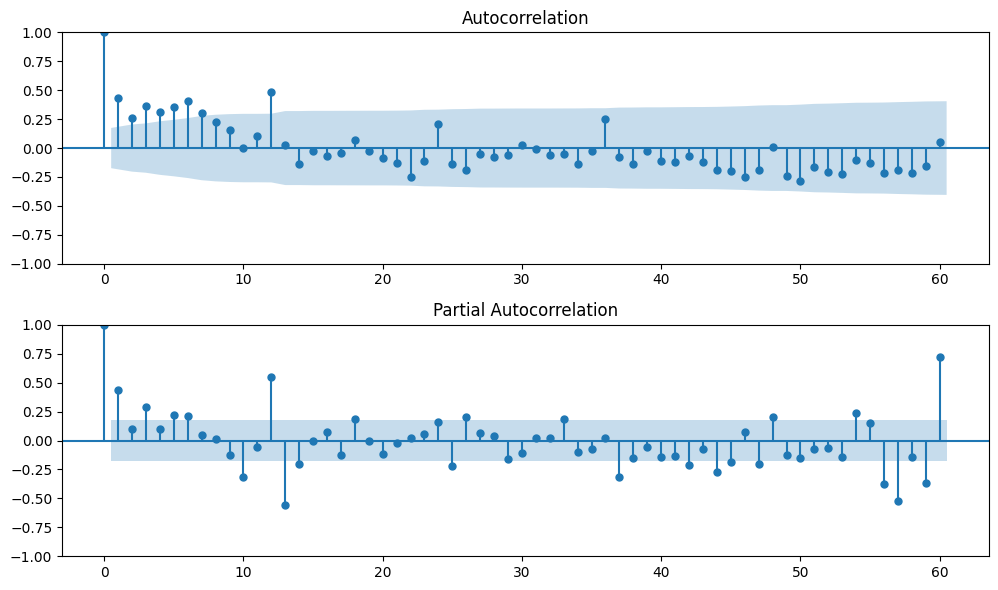

In [24]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
plot_acf(sales_data["TTL_TOPLAM"].dropna(),lags=60, ax=ax[0])
plot_pacf(sales_data["TTL_TOPLAM"].dropna(),lags=60, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

In [25]:
sales_data.columns

Index(['Date', 'TTL_TOPLAM', 'Month', 'Quarter', 'Year',
       'Tasit_Kredi_Faiz_Oran', 'Arac_Satin_Alim_Tufe', 'Genel_Enflasyon_Tufe',
       'Ticari_Bireysel_Kredi', 'Otomobil_Alma_Ihtimali', 'Issizlik_Oran',
       'Konut_Fiyat_Endeksi', 'USD_TL', 'Faiz', 'Mevduat_Faizi',
       'Genel_Enflasyon_Tufe_Change', 'Arac_Alim_Satim_Tufe_Change',
       'Ticari_Bireysel_Kredi_Change', 'Otomobil_Alma_Ihtimali_Change',
       'USD_TL_Change', 'Tasit_Kredi_Faiz_Oran_Change', 'Faiz_Change',
       'Mevduat_Faizi_Change', 'Konut_Fiyat_Endeksi_Change'],
      dtype='object')

In [28]:
##Add shifted values
###TTL_TOPLAM -> 1,3,6,12
sales_data["Sales_L1"] = sales_data.TTL_TOPLAM.shift(1)
sales_data["Sales_L3"] = sales_data.TTL_TOPLAM.shift(3)
sales_data["Sales_L6"] = sales_data.TTL_TOPLAM.shift(6)
sales_data["Sales_L12"] = sales_data.TTL_TOPLAM.shift(12)

features = [
    "Genel_Enflasyon_Tufe_Change","Arac_Alim_Satim_Tufe_Change",
    "Ticari_Bireysel_Kredi_Change","Otomobil_Alma_Ihtimali_Change",
    "USD_TL_Change","Tasit_Kredi_Faiz_Oran_Change","Konut_Fiyat_Endeksi_Change","Faiz_Change","Mevduat_Faizi_Change"
    ]

for i in features:
    for j in [1,3]:
        sales_data[i+"_L{}".format(j)] = sales_data[i].shift(j)

In [29]:
sales_data.head()

,Date,TTL_TOPLAM,Month,Quarter,Year,Tasit_Kredi_Faiz_Oran,Arac_Satin_Alim_Tufe,Genel_Enflasyon_Tufe,Ticari_Bireysel_Kredi,Otomobil_Alma_Ihtimali,...,USD_TL_Change_L1,USD_TL_Change_L3,Tasit_Kredi_Faiz_Oran_Change_L1,Tasit_Kredi_Faiz_Oran_Change_L3,Konut_Fiyat_Endeksi_Change_L1,Konut_Fiyat_Endeksi_Change_L3,Faiz_Change_L1,Faiz_Change_L3,Mevduat_Faizi_Change_L1,Mevduat_Faizi_Change_L3
0,2014-01-01,32670,1,1,2014,12.8400,151.68,233.54,639761215.0,15.112251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-02-01,35021,2,1,2014,15.0925,161.10,234.54,642644984.0,11.433624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-03-01,47581,3,1,2014,15.2100,166.94,237.18,647282258.0,11.333851,...,-0.183882,NaN,17.542835,NaN,1.092044,NaN,2.710843,NaN,17.795389,NaN
3,2014-04-01,53305,4,2,2014,14.9100,167.83,240.37,649650386.0,12.544490,...,0.227555,NaN,0.778532,NaN,1.388889,NaN,0.391007,NaN,6.445542,NaN
4,2014-05-01,58121,5,2,2014,14.2880,166.66,241.32,662454414.0,15.565597,...,-4.072685,-0.183882,-1.972387,17.542835,1.674277,1.092044,-2.336904,2.710843,-2.585635,17.795389


In [30]:
sales_data["month_sin"] = np.sin(2 * np.pi * sales_data.Date.dt.month / 12)
sales_data["month_cos"] = np.cos(2 * np.pi * sales_data.Date.dt.month / 12)

## shifted sma features

sales_data["Shifted1_SMA3"] = sales_data["TTL_TOPLAM"].shift(1).rolling(3).mean()
sales_data["Shifted1_SMA6"] = sales_data["TTL_TOPLAM"].shift(1).rolling(6).mean()
sales_data["Shifted1_SMA12"] = sales_data["TTL_TOPLAM"].shift(1).rolling(12).mean()

In [31]:
old_data = sales_data

In [32]:
sales_data.columns

Index(['Date', 'TTL_TOPLAM', 'Month', 'Quarter', 'Year',
       'Tasit_Kredi_Faiz_Oran', 'Arac_Satin_Alim_Tufe', 'Genel_Enflasyon_Tufe',
       'Ticari_Bireysel_Kredi', 'Otomobil_Alma_Ihtimali', 'Issizlik_Oran',
       'Konut_Fiyat_Endeksi', 'USD_TL', 'Faiz', 'Mevduat_Faizi',
       'Genel_Enflasyon_Tufe_Change', 'Arac_Alim_Satim_Tufe_Change',
       'Ticari_Bireysel_Kredi_Change', 'Otomobil_Alma_Ihtimali_Change',
       'USD_TL_Change', 'Tasit_Kredi_Faiz_Oran_Change', 'Faiz_Change',
       'Mevduat_Faizi_Change', 'Konut_Fiyat_Endeksi_Change', 'Sales_L1',
       'Sales_L3', 'Sales_L6', 'Sales_L12', 'Genel_Enflasyon_Tufe_Change_L1',
       'Genel_Enflasyon_Tufe_Change_L3', 'Arac_Alim_Satim_Tufe_Change_L1',
       'Arac_Alim_Satim_Tufe_Change_L3', 'Ticari_Bireysel_Kredi_Change_L1',
       'Ticari_Bireysel_Kredi_Change_L3', 'Otomobil_Alma_Ihtimali_Change_L1',
       'Otomobil_Alma_Ihtimali_Change_L3', 'USD_TL_Change_L1',
       'USD_TL_Change_L3', 'Tasit_Kredi_Faiz_Oran_Change_L1',
      

In [33]:
sales_data = sales_data.drop(features,axis=1)
sales_data = sales_data.drop([
    'Tasit_Kredi_Faiz_Oran', 'Arac_Satin_Alim_Tufe', 'Genel_Enflasyon_Tufe',
       'Ticari_Bireysel_Kredi', 'Otomobil_Alma_Ihtimali', 'Issizlik_Oran','USD_TL',
       "Konut_Fiyat_Endeksi","Faiz", "Mevduat_Faizi"],axis=1)
new_columns = sales_data.columns

In [34]:
old_data.columns

Index(['Date', 'TTL_TOPLAM', 'Month', 'Quarter', 'Year',
       'Tasit_Kredi_Faiz_Oran', 'Arac_Satin_Alim_Tufe', 'Genel_Enflasyon_Tufe',
       'Ticari_Bireysel_Kredi', 'Otomobil_Alma_Ihtimali', 'Issizlik_Oran',
       'Konut_Fiyat_Endeksi', 'USD_TL', 'Faiz', 'Mevduat_Faizi',
       'Genel_Enflasyon_Tufe_Change', 'Arac_Alim_Satim_Tufe_Change',
       'Ticari_Bireysel_Kredi_Change', 'Otomobil_Alma_Ihtimali_Change',
       'USD_TL_Change', 'Tasit_Kredi_Faiz_Oran_Change', 'Faiz_Change',
       'Mevduat_Faizi_Change', 'Konut_Fiyat_Endeksi_Change', 'Sales_L1',
       'Sales_L3', 'Sales_L6', 'Sales_L12', 'Genel_Enflasyon_Tufe_Change_L1',
       'Genel_Enflasyon_Tufe_Change_L3', 'Arac_Alim_Satim_Tufe_Change_L1',
       'Arac_Alim_Satim_Tufe_Change_L3', 'Ticari_Bireysel_Kredi_Change_L1',
       'Ticari_Bireysel_Kredi_Change_L3', 'Otomobil_Alma_Ihtimali_Change_L1',
       'Otomobil_Alma_Ihtimali_Change_L3', 'USD_TL_Change_L1',
       'USD_TL_Change_L3', 'Tasit_Kredi_Faiz_Oran_Change_L1',
      

In [35]:
new_columns

Index(['Date', 'TTL_TOPLAM', 'Month', 'Quarter', 'Year', 'Sales_L1',
       'Sales_L3', 'Sales_L6', 'Sales_L12', 'Genel_Enflasyon_Tufe_Change_L1',
       'Genel_Enflasyon_Tufe_Change_L3', 'Arac_Alim_Satim_Tufe_Change_L1',
       'Arac_Alim_Satim_Tufe_Change_L3', 'Ticari_Bireysel_Kredi_Change_L1',
       'Ticari_Bireysel_Kredi_Change_L3', 'Otomobil_Alma_Ihtimali_Change_L1',
       'Otomobil_Alma_Ihtimali_Change_L3', 'USD_TL_Change_L1',
       'USD_TL_Change_L3', 'Tasit_Kredi_Faiz_Oran_Change_L1',
       'Tasit_Kredi_Faiz_Oran_Change_L3', 'Konut_Fiyat_Endeksi_Change_L1',
       'Konut_Fiyat_Endeksi_Change_L3', 'Faiz_Change_L1', 'Faiz_Change_L3',
       'Mevduat_Faizi_Change_L1', 'Mevduat_Faizi_Change_L3', 'month_sin',
       'month_cos', 'Shifted1_SMA3', 'Shifted1_SMA6', 'Shifted1_SMA12'],
      dtype='object')

In [42]:
##Create Future Dataset

forecasting_date = pd.to_datetime("2024-08-01")
forecasting_date_L1 = forecasting_date + pd.DateOffset(months= -1)
forecasting_date_L3 = forecasting_date + pd.DateOffset(months= -3)
forecasting_date_L6 = forecasting_date + pd.DateOffset(months= -6)
forecasting_date_L12 = forecasting_date + pd.DateOffset(months = -12)


## 1. gecikmeler
d = {}
for i in new_columns[new_columns.str.endswith("L1")]:
    col_name = i[0:-3]
    if col_name == "Sales":
        col_name = "TTL_TOPLAM"
    d[i] = old_data[old_data.Date == forecasting_date_L1][col_name].values.flatten()


## 3.gecikmeler
for i in new_columns[new_columns.str.endswith("L3")]:
    col_name = i[0:-3]
    if col_name == "Sales":
        col_name = "TTL_TOPLAM"
    d[i] = old_data[old_data.Date == forecasting_date_L3][col_name].values.flatten()


## 6.gecikmeler
for i in new_columns[new_columns.str.endswith("L6")]:
    col_name = i[0:-3]
    if col_name == "Sales":
        col_name = "TTL_TOPLAM"
    d[i] = old_data[old_data.Date == forecasting_date_L6][col_name].values.flatten()


## 12.gecikmeler
for i in new_columns[new_columns.str.endswith("L12")]:
    col_name = i[0:-4]
    if col_name == "Sales":
        col_name = "TTL_TOPLAM"
    d[i] = old_data[old_data.Date == forecasting_date_L12][col_name].values.flatten()



future_frame = pd.DataFrame(d)
future_frame["ds"] = forecasting_date
future_frame["Month"] = forecasting_date.month
future_frame["Year"] = forecasting_date.year
future_frame["Quarter"] = forecasting_date.quarter
future_frame["month_sin"] = np.sin(2 * np.pi * forecasting_date.month / 12)
future_frame["month_cos"] = np.cos(2 * np.pi * forecasting_date.month / 12)
future_frame['Shifted1_SMA3'] = sales_data['Shifted1_SMA3'].iloc[-3:].mean()
future_frame['Shifted1_SMA6'] = sales_data['Shifted1_SMA6'].iloc[-6:].mean()
future_frame['Shifted1_SMA12'] = sales_data['Shifted1_SMA12'].iloc[-12:].mean()

In [93]:
train_set = sales_data[sales_data.Date < '2023-11-01']
test_set = sales_data[sales_data.Date >= '2023-11-01']
X_Train = train_set.drop(["Date","TTL_TOPLAM"],axis = 1)
X_Test = test_set.drop(["Date","TTL_TOPLAM"],axis = 1)
y_train = train_set["TTL_TOPLAM"]
y_test = test_set["TTL_TOPLAM"]

In [81]:
scaler = MinMaxScaler()
X_Train = scaler.fit_transform(X_Train.fillna(0))
X_Test = scaler.transform(X_Test)

In [94]:
iteration = range(100,600,100)
learning_rate = [.1,.2,.3,.5,.7,.85,.90]
depth = [2,4]
l2_leaf_reg = [.1,.2,.3]


best_score = np.inf
best_params = {}

for i in iteration:
    for j in learning_rate:
        for k in depth:
            for l in l2_leaf_reg:
                cb_model = CatBoostRegressor(iterations=i,learning_rate=j,depth=k,l2_leaf_reg= l,verbose=False,random_seed=42)
                cb_model.fit(X_Train,y_train)
                predict = cb_model.predict(X_Test)
                mae = mean_absolute_error(predict,y_test)
                print(mae)


                if mae < best_score:
                    best_score = mae
                    best_params["iter"] = i
                    best_params["lr"] = j
                    best_params["depth"] = k
                    best_params["l2_leaf"] = l
                    best_params["score"] = best_score


13559.427704853411
14331.200689345518
14604.911676546933
14322.276597609418
13912.695226356927
18202.786084182604
13341.699533521254
13144.97039051446
13470.475305927182
11720.982134108945
11268.325651192214
10603.391300373874
13490.895229019407
11795.688379397026
14484.107391206615
14368.910779493304
12741.728508335465
11778.866663216606
13226.512701455851
10707.719724132745
10990.182377830206
15389.720170727802
13710.637572889806
14391.800591907642
12967.041405066413
11010.79633890761
13133.438904464821
8359.62086146632
13674.648754310449
15651.002520184797
17589.178796878823
21976.03559253305
17492.722160730937
12154.343878889904
14103.825751129889
17903.209260347638
21391.378539094643
22453.370903361814
18564.605946934218
35982.734749125324
19315.192745472308
19951.90999617899
12309.459056662568
13196.080323281749
12896.015167501591
13845.766886000907
13999.14689371689
18286.302639438938
13973.849793591984
12950.395669206424
13608.727115793366
11649.06359644923
11229.115740843841
1

CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/algo/tensor_search_helpers.cpp:554: Too few sampling units (subsample=0.8, bootstrap_type=MVS): please increase sampling rate or disable sampling

In [95]:
best_params

{'iter': 300,
 'lr': 0.7,
 'depth': 4,
 'l2_leaf': 0.1,
 'score': 8359.601491035055}

In [96]:
## Create basic model
cb_model = CatBoostRegressor(iterations=300,learning_rate=0.7,depth=4,l2_leaf_reg= 0.1,random_seed=42)#CatBoostRegressor(iterations=500,learning_rate=0.85,depth=2,fold_len_multiplier=2.5,l2_leaf_reg= 0.3)
cb_model.fit(X_Train,y_train)
predict = cb_model.predict(X_Test)

0:	learn: 21370.8616024	total: 806us	remaining: 241ms
1:	learn: 17471.5398036	total: 1.47ms	remaining: 219ms
2:	learn: 14740.5676979	total: 2.06ms	remaining: 204ms
3:	learn: 12459.6939183	total: 2.65ms	remaining: 196ms
4:	learn: 10431.4365758	total: 3.25ms	remaining: 192ms
5:	learn: 9126.2030750	total: 3.84ms	remaining: 188ms
6:	learn: 7549.1649605	total: 4.46ms	remaining: 187ms
7:	learn: 6240.2826784	total: 5.04ms	remaining: 184ms
8:	learn: 5315.2183080	total: 5.62ms	remaining: 182ms
9:	learn: 4537.8749922	total: 6.25ms	remaining: 181ms
10:	learn: 3660.8396447	total: 6.87ms	remaining: 180ms
11:	learn: 3053.7323688	total: 7.49ms	remaining: 180ms
12:	learn: 2541.3743283	total: 8.13ms	remaining: 179ms
13:	learn: 2245.8410061	total: 8.74ms	remaining: 179ms
14:	learn: 1922.9470552	total: 9.39ms	remaining: 179ms
15:	learn: 1649.8684706	total: 10.1ms	remaining: 179ms
16:	learn: 1387.7023108	total: 10.7ms	remaining: 179ms
17:	learn: 1268.9518070	total: 11.8ms	remaining: 185ms
18:	learn: 1114.

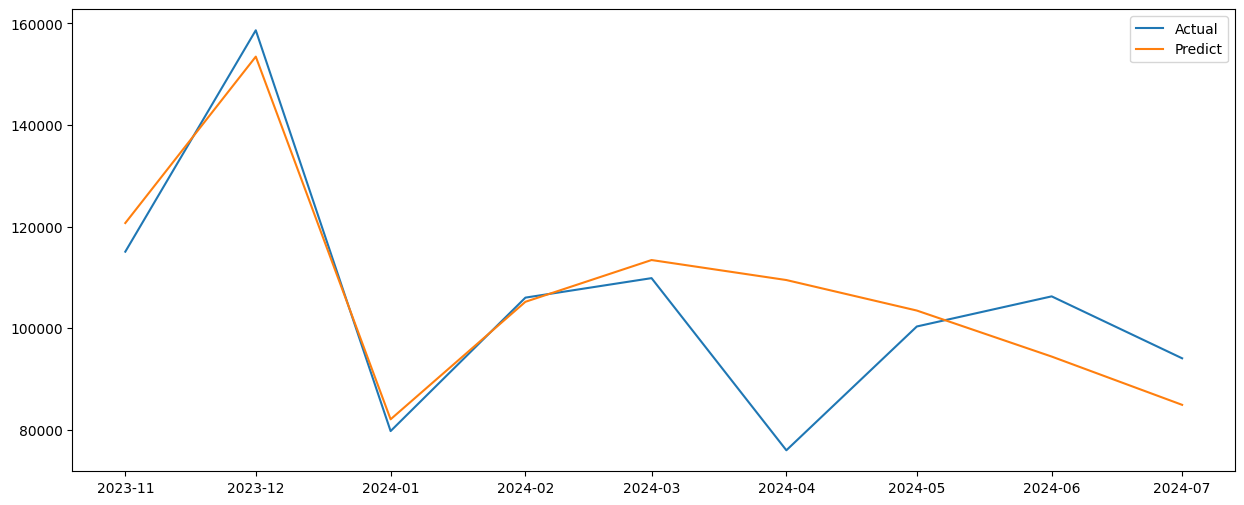

In [97]:
plt.figure(figsize=(15,6))
plt.plot(test_set.Date,y_test,label = "Actual")
plt.plot(test_set.Date,predict,label = "Predict")
plt.legend()
plt.show()

In [98]:
mean_absolute_error(y_true=y_test,y_pred=predict)

8359.601491035055

In [99]:
smape(y_true=y_test,y_pred=predict)

8.47601858121141

In [100]:
## Set all data for training
all_data_train = sales_data.drop(["Date","TTL_TOPLAM"],axis = 1)
all_data_y = sales_data.TTL_TOPLAM
all_data_train.head()

scaler = MinMaxScaler()
scaler.fit(all_data_train.fillna(0))
X_Train = scaler.transform(X_Train)

In [103]:
#### Create model for all data

cb_model = CatBoostRegressor(iterations=300,learning_rate=0.7,depth=4,l2_leaf_reg= 0.1,random_seed=42,verbose=False)#CatBoostRegressor(iterations=500,learning_rate=0.85,depth=2,fold_len_multiplier=2.5,l2_leaf_reg= 0.3)
cb_model.fit(all_data_train,all_data_y)

predict_cb = cb_model.predict(future_frame[all_data_train.columns])

In [104]:
predict_cb

array([74987.55917917])

### Arima

In [105]:
## set train & test set for arima

train_set = train_set.set_index(train_set.Date)
train_set = train_set.asfreq('MS')
train_set = train_set.sort_index()

test_set = test_set.set_index(test_set.Date)
test_set = test_set.asfreq('MS')
test_set = test_set.sort_index()

exog_cols = ['Month', 'Quarter', 'Year', 'Sales_L1',
       'Sales_L3', 'Sales_L6', 'Sales_L12', 'Genel_Enflasyon_Tufe_Change_L1',
       'Genel_Enflasyon_Tufe_Change_L3', 'Arac_Alim_Satim_Tufe_Change_L1',
       'Arac_Alim_Satim_Tufe_Change_L3', 'Ticari_Bireysel_Kredi_Change_L1',
       'Ticari_Bireysel_Kredi_Change_L3', 'Otomobil_Alma_Ihtimali_Change_L1',
       'Otomobil_Alma_Ihtimali_Change_L3', 'USD_TL_Change_L1',
       'USD_TL_Change_L3', 'Tasit_Kredi_Faiz_Oran_Change_L1',
       'Tasit_Kredi_Faiz_Oran_Change_L3', 'Konut_Fiyat_Endeksi_Change_L1',
       'Konut_Fiyat_Endeksi_Change_L3',"Faiz_Change_L1","Faiz_Change_L3","Mevduat_Faizi_Change_L1",
       "Mevduat_Faizi_Change_L3",'month_sin', 'month_cos',"Shifted1_SMA3","Shifted1_SMA6","Shifted1_SMA12"]

X_Train = train_set.drop(["Date","TTL_TOPLAM"],axis= 1 )
X_Test = test_set.drop(["Date","TTL_TOPLAM"],axis= 1 )
y_train = train_set["TTL_TOPLAM"]
y_test = test_set["TTL_TOPLAM"]

In [149]:
import statsmodels.api as sm

arima = sm.tsa.statespace.SARIMAX(y_train,exog=X_Train.fillna(method="bfill"),order=(0,1,0),seasonal_order=(0,1,0,6),
                                 enforce_stationarity=False, enforce_invertibility= False,freq="MS").fit()
arima.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        TTL_TOPLAM   No. Observations:                  118
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 6)   Log Likelihood               -1416.254
Date:                           Fri, 09 Aug 2024   AIC                           2894.507
Time:                                   23:20:18   BIC                           2978.222
Sample:                               01-01-2014   HQIC                          2928.463
                                    - 10-01-2023                                         
Covariance Type:                             opg                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Month                             3527.0194   1.08e+05      0.033      0.974   -2.09e+05    2.16e+05
Quarter                           1175.6731   3.62e+04      0.033      0.974   -6.97e+04     7.2e+04
Year                              -293.9183   9038.448     -0.033      0.974    -1.8e+04    1.74e+04
Sales_L1                            -0.0332     12.191     -0.003      0.998     -23.928      23.861
Sales_L3                             0.0796      8.949      0.009      0.993     -17.461      17.620
Sales_L6                            -0.7019     11.160     -0.063      0.950     -22.575      21.171
Sales_L12                           -0.2351      8.996     -0.026      0.979     -17.866      17.396
Genel_Enflasyon_Tufe_Change_L1     127.7273   1.61e+05      0.001      0.999   -3.16e+05    3.17e+05
Genel_Enflasyon_Tufe_Change_L3   -1214.9582   1.43e+05     -0.008      0.993   -2.82e+05    2.79e+05
Arac_Alim_Satim_Tufe_Change_L1     744.3364   5.14e+04      0.014      0.988   -9.99e+04    1.01e+05
Arac_Alim_Satim_Tufe_Change_L3     469.8491   4.56e+04      0.010      0.992   -8.89e+04    8.99e+04
Ticari_Bireysel_Kredi_Change_L1  -2179.5215   1.61e+05     -0.014      0.989   -3.19e+05    3.14e+05
Ticari_Bireysel_Kredi_Change_L3   1858.7924   1.43e+05      0.013      0.990   -2.79e+05    2.83e+05
Otomobil_Alma_Ihtimali_Change_L1  -118.4829   8384.309     -0.014      0.989   -1.66e+04    1.63e+04
Otomobil_Alma_Ihtimali_Change_L3    44.5992    1.1e+04      0.004      0.997   -2.15e+04    2.16e+04
USD_TL_Change_L1                  -804.8170   5.04e+04     -0.016      0.987   -9.96e+04     9.8e+04
USD_TL_Change_L3                  -596.7688   6.24e+04     -0.010      0.992   -1.23e+05    1.22e+05
Tasit_Kredi_Faiz_Oran_Change_L1   -385.9565   3.69e+04     -0.010      0.992   -7.26e+04    7.19e+04
Tasit_Kredi_Faiz_Oran_Change_L3   -118.2559   4.53e+04     -0.003      0.998   -8.89e+04    8.86e+04
Konut_Fiyat_Endeksi_Change_L1      424.0272   2.16e+05      0.002      0.998   -4.22e+05    4.23e+05
Konut_Fiyat_Endeksi_Change_L3     2043.6155   2.03e+05      0.010      0.992   -3.96e+05       4e+05
Faiz_Change_L1                     220.7692   2.46e+04      0.009      0.993    -4.8e+04    4.84e+04
Faiz_Change_L3                    -105.9430   2.74e+04     -0.004      0.997   -5.38e+04    5.36e+04
Mevduat_Faizi_Change_L1           -142.0235   3.88e+04     -0.004      0.997   -7.61e+04    7.58e+04
Mevduat_Faizi_Change_L3             50.5934   5.32e+04      0.001      0.999   -1.04e+05    1.04e+05
month_sin                         1.392e+04   5.55e+05      0.025      0.980   -1.07e+06     1.1e+06
month_cos                         1396.5238   5.01e+05      0.003      0.998    -9.8e+05    9.83e+05
Shifted1_SMA3                       -0.7296     44.150     -0.017      0.987     -87.262      85.803
Shifted1_SM

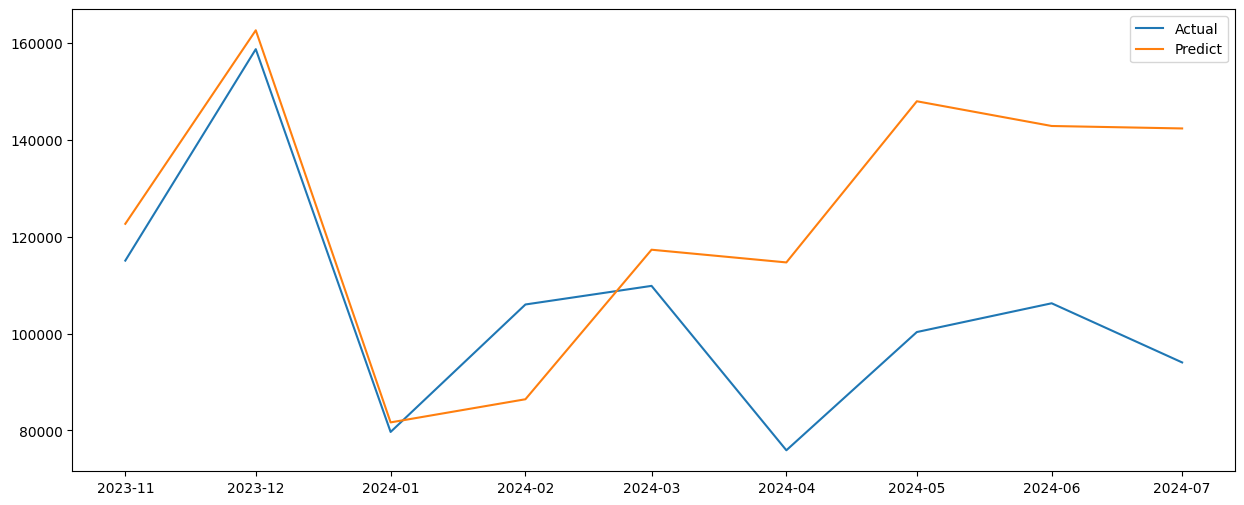

In [150]:
te_start,te_end = '2023-11-01','2024-07-01'

pred = arima.predict(te_start,te_end,exog = X_Test)

plt.figure(figsize=(15,6))
plt.plot(test_set.Date,y_test,label = "Actual")
plt.plot(test_set.Date,pred,label = "Predict")
plt.legend()
plt.show()

In [144]:
mean_absolute_error(y_pred= pred,y_true= y_test)

16292.968663954383

In [136]:
smape(y_pred= pred,y_true= y_test)

19.02079445385914

#### Prophet

In [151]:
new_columns = sales_data.columns

In [152]:
t = test_set[new_columns].reset_index(drop = True)
t = t.rename(columns={"Date":"ds","TTL_TOPLAM":"y"})
t_y = t[["y"]]
t_y.columns = ["y"]

In [153]:
a = sales_data.isna().sum().reset_index()
a.columns = ["column","NA"]

In [154]:
from prophet import Prophet
f = train_set.reset_index(drop= True)
f = f[new_columns]
f = f.rename(columns={"Date":"ds","TTL_TOPLAM":"y"})

for j in a[a.NA > 0]["column"].values:
    f[j] = f[j].fillna(0)


m = Prophet(interval_width=0.95,changepoint_prior_scale=0.0001,changepoint_range=0.5)
m.add_seasonality(name='monthly', period=60.5, fourier_order=2,prior_scale=0.3)


for i in [x for x in exog_cols if x not in exog_cols[-5:-3]]:
    print(i," added in Prophet Model.")
    m.add_regressor(i,standardize=True,mode='additive')

m.add_regressor("month_sin",standardize=False,mode='additive')
m.add_regressor("month_cos",standardize=False,mode='additive')

m.fit(f)
#forecast = m.predict(t_p)  

23:20:46 - cmdstanpy - INFO - Chain [1] start processing
23:20:46 - cmdstanpy - INFO - Chain [1] done processing
23:20:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:20:47 - cmdstanpy - INFO - Chain [1] start processing


Month  added in Prophet Model.
Quarter  added in Prophet Model.
Year  added in Prophet Model.
Sales_L1  added in Prophet Model.
Sales_L3  added in Prophet Model.
Sales_L6  added in Prophet Model.
Sales_L12  added in Prophet Model.
Genel_Enflasyon_Tufe_Change_L1  added in Prophet Model.
Genel_Enflasyon_Tufe_Change_L3  added in Prophet Model.
Arac_Alim_Satim_Tufe_Change_L1  added in Prophet Model.
Arac_Alim_Satim_Tufe_Change_L3  added in Prophet Model.
Ticari_Bireysel_Kredi_Change_L1  added in Prophet Model.
Ticari_Bireysel_Kredi_Change_L3  added in Prophet Model.
Otomobil_Alma_Ihtimali_Change_L1  added in Prophet Model.
Otomobil_Alma_Ihtimali_Change_L3  added in Prophet Model.
USD_TL_Change_L1  added in Prophet Model.
USD_TL_Change_L3  added in Prophet Model.
Tasit_Kredi_Faiz_Oran_Change_L1  added in Prophet Model.
Tasit_Kredi_Faiz_Oran_Change_L3  added in Prophet Model.
Konut_Fiyat_Endeksi_Change_L1  added in Prophet Model.
Konut_Fiyat_Endeksi_Change_L3  added in Prophet Model.
Faiz_Ch

23:20:48 - cmdstanpy - INFO - Chain [1] done processing


In [155]:
forecast = m.predict(t.drop(["y"],axis = 1))

In [156]:
from prophet.plot import plot_plotly
import plotly.offline as py 

fig = plot_plotly(m,forecast)
py.iplot(fig)

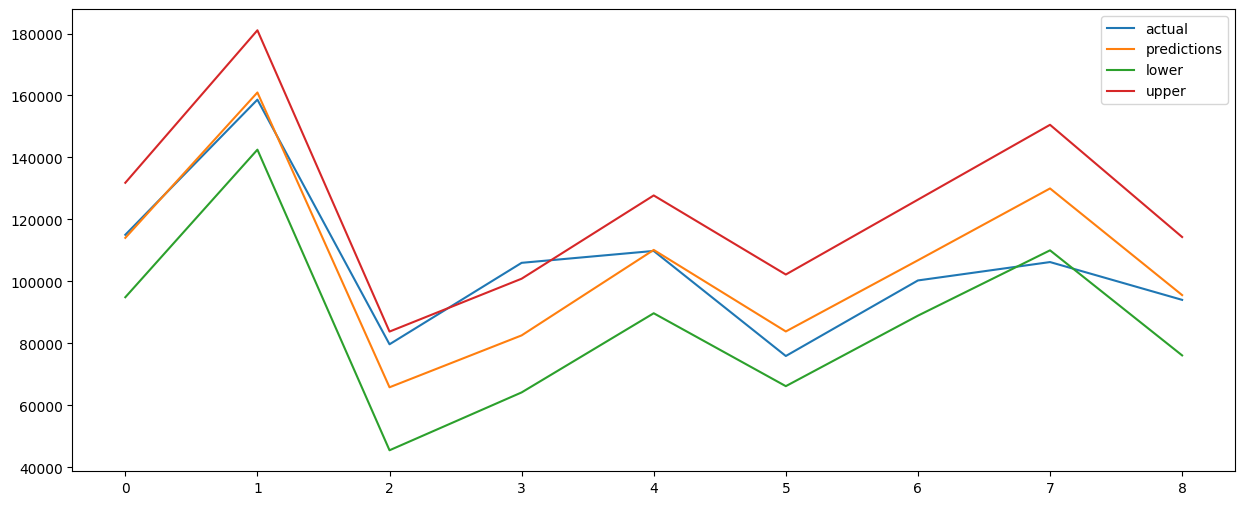

In [157]:
plt.figure(figsize=(15,6))
plt.plot(np.array(y_test), label='actual')
plt.plot(forecast["yhat"], label='predictions')
plt.plot(forecast["yhat_lower"], label='lower')
plt.plot(forecast["yhat_upper"], label='upper')
plt.legend()
plt.show()

In [158]:
smape(y_true=y_test,y_pred=forecast["yhat"])

9.385244674491519

In [159]:
mean_absolute_error(y_true=y_test,y_pred=forecast["yhat"])


8962.327012435017

In [161]:
from sklearn.model_selection import ParameterGrid, ParameterSampler
import numpy as np

# Hyperparameter aralıkları
param_grid = {
    'changepoint_prior_scale': [0.0001, 0.01, 0.1, 0.5,0.7,0.9],
    'seasonality_prior_scale': [0.01, 0.1,0.3,0.5, 1.0, 10.0],
    'changepoint_range': [0.1,0.3,0.5,0.8, 0.9,1]
}

# Grid Search kullanarak parametre kombinasyonları oluşturun
param_list = list(ParameterGrid(param_grid))

best_score = float('inf')
best_params = None


t_p = t.drop(["y"],axis = 1)
y = t["y"]


# Tüm parametre kombinasyonlarını dene
for params in param_list:
    m = Prophet(interval_width=0.95,
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                changepoint_range=params['changepoint_range'])
    
    # Regresörleri tekrar ekleyin
    #m.add_seasonality(name='monthly', period=60.5, fourier_order=5, prior_scale=0.75)
    m.add_seasonality(name='monthly', period=60.5, fourier_order=2,prior_scale=0.3)
    for i in [x for x in exog_cols if x not in exog_cols[-5:-3]]:
        m.add_regressor(i, standardize=True, mode='additive')


    m.add_regressor("month_sin", standardize=False, mode='additive')
    m.add_regressor("month_cos", standardize=False, mode='additive')
    
    # Modeli eğitin
    m.fit(f)
    
    # Modeli değerlendir
    forecast = m.predict(t_p)
    
    # Tahminlerinizi değerlendirmek için bir hata metriği kullanın
    mse = mean_absolute_error(y_pred=forecast['yhat'],y_true=y)  # Ortalama kare hatayı hesapla
    
    if mse < best_score:
        best_score = mse
        best_params = params

print("Best Parameters:", best_params)
print("Best MSE:", best_score)


23:23:18 - cmdstanpy - INFO - Chain [1] start processing
23:23:18 - cmdstanpy - INFO - Chain [1] done processing
23:23:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:23:18 - cmdstanpy - INFO - Chain [1] start processing
23:23:18 - cmdstanpy - INFO - Chain [1] done processing
23:23:18 - cmdstanpy - INFO - Chain [1] start processing
23:23:18 - cmdstanpy - INFO - Chain [1] done processing
23:23:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:23:18 - cmdstanpy - INFO - Chain [1] start processing
23:23:19 - cmdstanpy - INFO - Chain [1] done processing
23:23:19 - cmdstanpy - INFO - Chain [1] start processing
23:23:19 - cmdstanpy - INFO - Chain [1] done processing
23:23:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Best Parameters: {'changepoint_prior_scale': 0.0001, 'changepoint_range': 0.5, 'seasonality_prior_scale': 10.0}
Best MSE: 8962.327012435017


In [154]:
best_params

{'changepoint_prior_scale': 0.01,
 'changepoint_range': 0.9,
 'holidays_prior_scale': 0.01,
 'seasonality_prior_scale': 0.1}

### HistGradientBoosting

In [171]:
### Tum veri ile modeli kur

## Sonraki ay verisinin oluşturulması
t = test_set[new_columns].reset_index(drop = True)
t = t.rename(columns={"Date":"ds","TTL_TOPLAM":"y"})
t_y = t[["y"]]
t_y.columns = ["y"]


from prophet import Prophet
f = sales_data.reset_index(drop= True)
f = f[new_columns]
f = f.rename(columns={"Date":"ds","TTL_TOPLAM":"y"})

for j in a[a.NA > 0]["column"].values:
    f[j] = f[j].fillna(f[j].mean())

m = Prophet(interval_width=0.5,changepoint_prior_scale=0.0001,changepoint_range=0.5,seasonality_prior_scale=10)
m.add_seasonality(name='monthly', period=60.5, fourier_order=2,prior_scale=0.3)

#m.add_seasonality(name='monthly', period=60.5, fourier_order=5,prior_scale=0.75)

for i in exog_cols[:-2]:
    m.add_regressor(i,standardize=True,mode='additive')


m.add_regressor("month_sin",standardize=False,mode='additive')
m.add_regressor("month_cos",standardize=False,mode='additive')


m.fit(f)

pred_prophet = m.predict(future_frame)




23:58:59 - cmdstanpy - INFO - Chain [1] start processing
23:58:59 - cmdstanpy - INFO - Chain [1] done processing
23:58:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:58:59 - cmdstanpy - INFO - Chain [1] start processing
23:59:00 - cmdstanpy - INFO - Chain [1] done processing


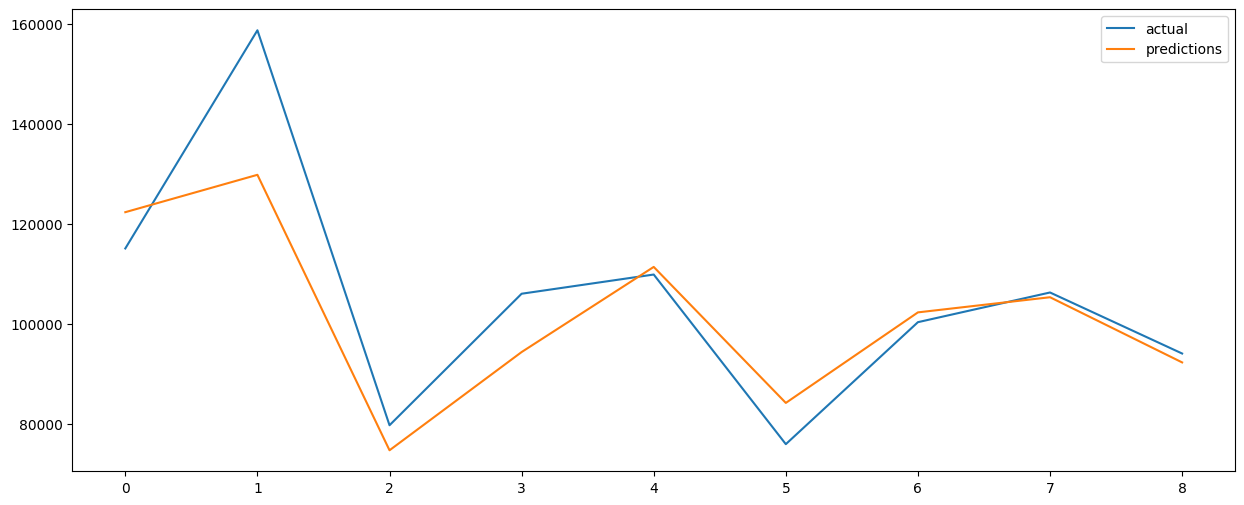

SMAPE :  6.742500000555716
MAE :  7472.891519218201


In [169]:
gbrt = HistGradientBoostingRegressor(loss="quantile",quantile=0.75,learning_rate=.9,max_bins=15,max_depth=1,l2_regularization=0.9).fit(X_Train,y_train)
pred = gbrt.predict(X_Test)

plt.figure(figsize=(15,6))
plt.plot(np.array(y_test), label='actual')
plt.plot(pred, label='predictions')
plt.legend()
plt.show()


print("SMAPE : ",smape(y_true=y_test,y_pred=pred))

print("MAE : ",mean_absolute_error(y_true=y_test,y_pred=pred))


In [174]:
gbrt_all = HistGradientBoostingRegressor(loss="quantile",quantile=0.75,learning_rate=.9,max_bins=15,max_depth=1,l2_regularization=0.9).fit(all_data_train,all_data_y)
pred_gbrt = gbrt.predict(future_frame[all_data_train.columns])


[80574.35479896]


In [ ]:
## Tahminler
### 2024 Temmuz için tahmin : 90805.185071
### 2024 Temmuz Alt sınır 73505
### 2024 Temmuz Üst sınır 108276
###### 2024 Temmuz Gerceklesen : 94037


# CatBoost
### 2024 Agustos için tahmin : 74987.55917917

# HistogramGradiantBoosting
### 2024 Agustos için tahmin : 80574.35479896

# Prophet
### 2024 Agustos için tahmin : 87555
### 2024 Agustos Alt sınır : 80826.295394
### 2024 Agustos Üst sınır : 94676.662245


## Ağustos 3 Model Ortalaması : 81,038.66

###### 2024 Agustos Gerceklesen : 


In [176]:
pred_gbrt

array([80574.35479896])